In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import  StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
RANDOM_SEED = 0

df = pd.read_csv('insurance_cross_sell.csv', index_col=0)
print(df.head())

    Gender  Age  Driving_License  Region_Code  Previously_Insured Vehicle_Age  \
id                                                                              
1     Male   44                1         28.0                   0   > 2 Years   
2     Male   76                1          3.0                   0    1-2 Year   
3     Male   47                1         28.0                   0   > 2 Years   
4     Male   21                1         11.0                   1    < 1 Year   
5   Female   29                1         41.0                   1    < 1 Year   

   Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  Response  
id                                                                          
1             Yes         40454.0                  26.0      217         1  
2              No         33536.0                  26.0      183         0  
3             Yes         38294.0                  26.0       27         1  
4              No         28619.0              

In [3]:
print(df['Age'].describe())
print(df['Annual_Premium'].describe())
print(df['Vintage'].describe())

count    381109.000000
mean         38.822584
std          15.511611
min          20.000000
25%          25.000000
50%          36.000000
75%          49.000000
max          85.000000
Name: Age, dtype: float64
count    381109.000000
mean      30564.389581
std       17213.155057
min        2630.000000
25%       24405.000000
50%       31669.000000
75%       39400.000000
max      540165.000000
Name: Annual_Premium, dtype: float64
count    381109.000000
mean        154.347397
std          83.671304
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64


Settings per i grafici

In [4]:
plt.rcParams["figure.figsize"] = (16,10)
sns.set_theme(style='dark')

In [5]:
def plot_frequency_distribution(X, feature_name=None):
    FONT_SIZE = 16
    
    relative_frequency = X.value_counts(normalize = True)*100
    print(relative_frequency)
    ax = relative_frequency.plot.bar(rot=45, fontsize=FONT_SIZE)
    pf = PercentFormatter(xmax=100,decimals=2)
    ax.yaxis.set_major_formatter(pf)
    ax.bar_label(ax.containers[0], fmt='%.2f%%', fontsize=FONT_SIZE)
    plt.ylabel('Frequency (%)', fontsize=FONT_SIZE)
    plt.xlabel('Categories',fontsize=FONT_SIZE)
    plt.ylim((0,100))
    if feature_name != None:
        plt.title(f"Relative frequency distribution for {feature_name} feature",
                 fontsize=FONT_SIZE)
    plt.show()

In [6]:
def plot_quantitative_distribution(X, feature_name=None, discrete=False):
    FONT_SIZE = 16  
    if(discrete):
        #histogram
        fig, axs = plt.subplots(2,1,sharex=True)
        sns.histplot(x=X, discrete=True, ax = axs[0])
        axs[0].set_ylabel("Count", fontsize=FONT_SIZE)
        axs[0].tick_params(axis='y', labelsize=FONT_SIZE)
        
        #boxplot
        sns.boxplot(x=X,width=.5,ax = axs[1])
        plt.tight_layout()
    else:
        sns.violinplot(x=X)
        sns.despine(left=True)
        
    plt.xticks(fontsize=FONT_SIZE)
    if feature_name != None:
        plt.xlabel(feature_name, fontsize=FONT_SIZE)
        plt.suptitle(f"{feature_name} distribution", fontsize=FONT_SIZE)
    plt.show()

Gender
Male      54.07613
Female    45.92387
Name: proportion, dtype: float64


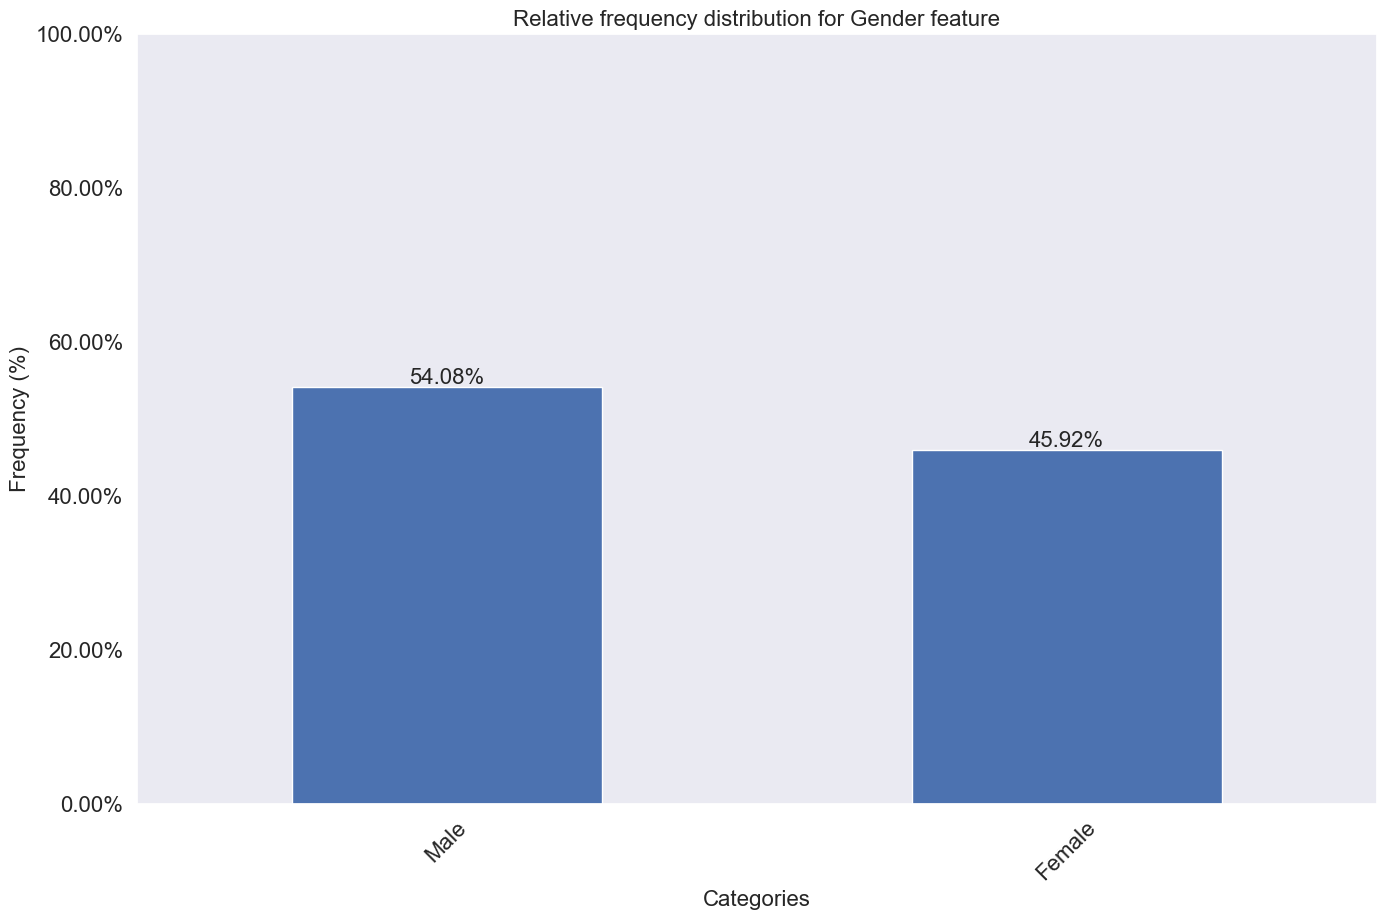

In [7]:
plot_frequency_distribution(df["Gender"], 'Gender')

I due insiemi maschi e femmine risultano abbastanza bilanciati

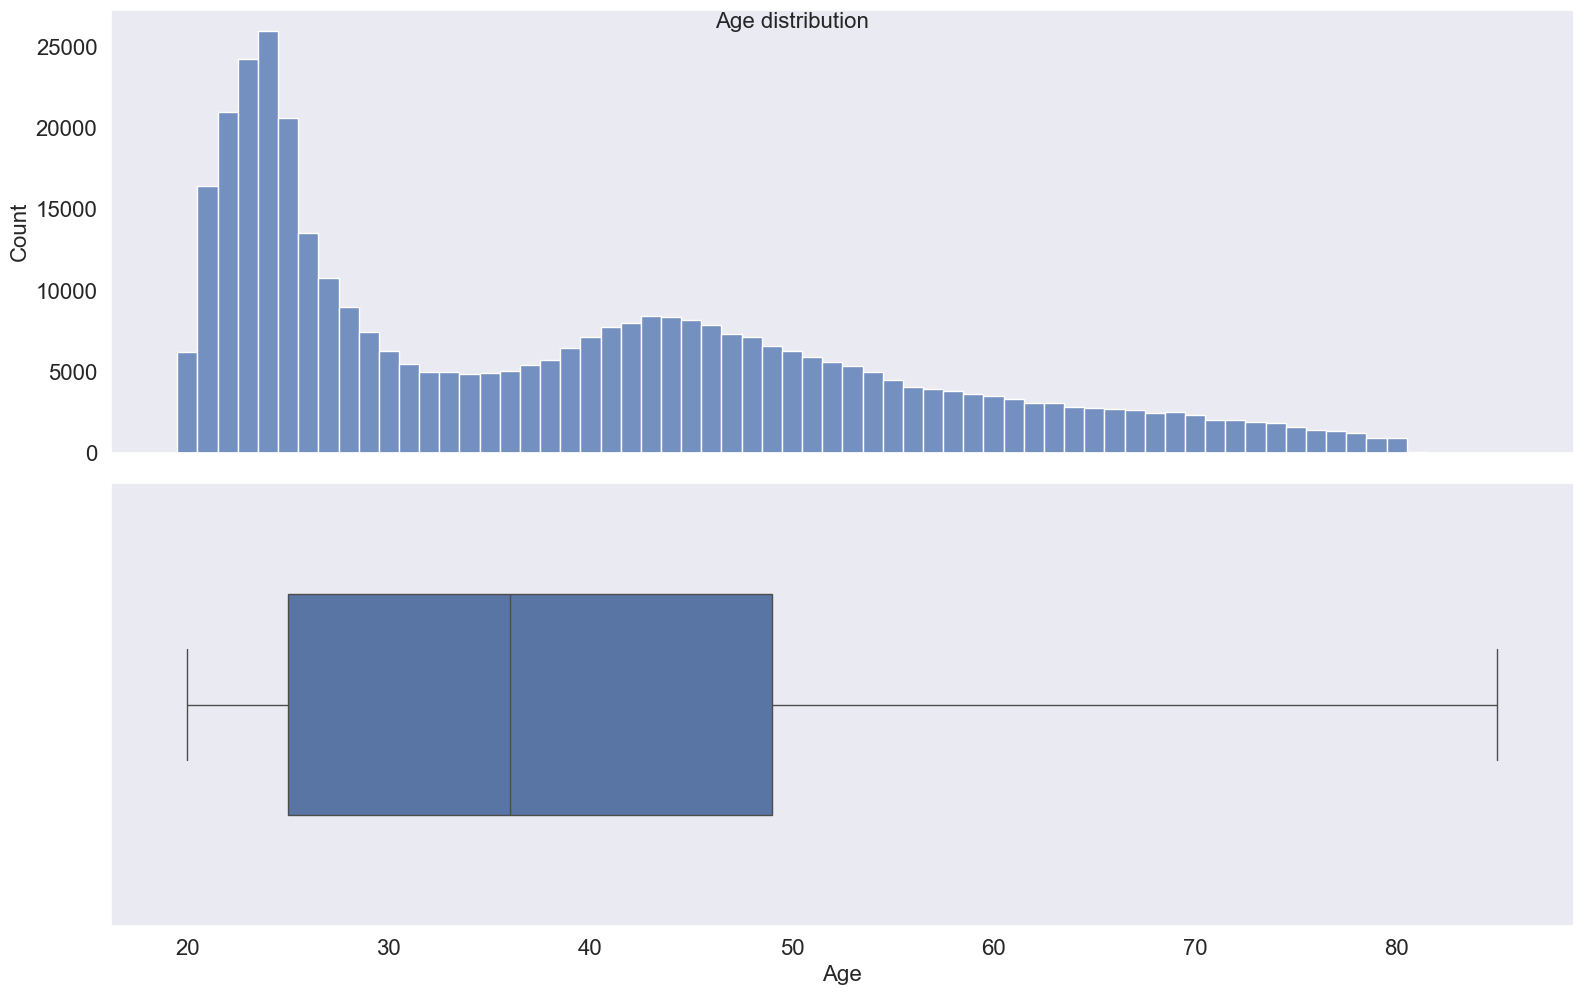

In [8]:
plot_quantitative_distribution(df["Age"],'Age',True)

C'è un gran numero di persone tra i 20 e i 30 anni, poi va diminuinendo ad eccezione di un leggero aumento tra i 40 e i 50 anni.

Driving_License
YES    99.786938
NO      0.213062
Name: proportion, dtype: float64


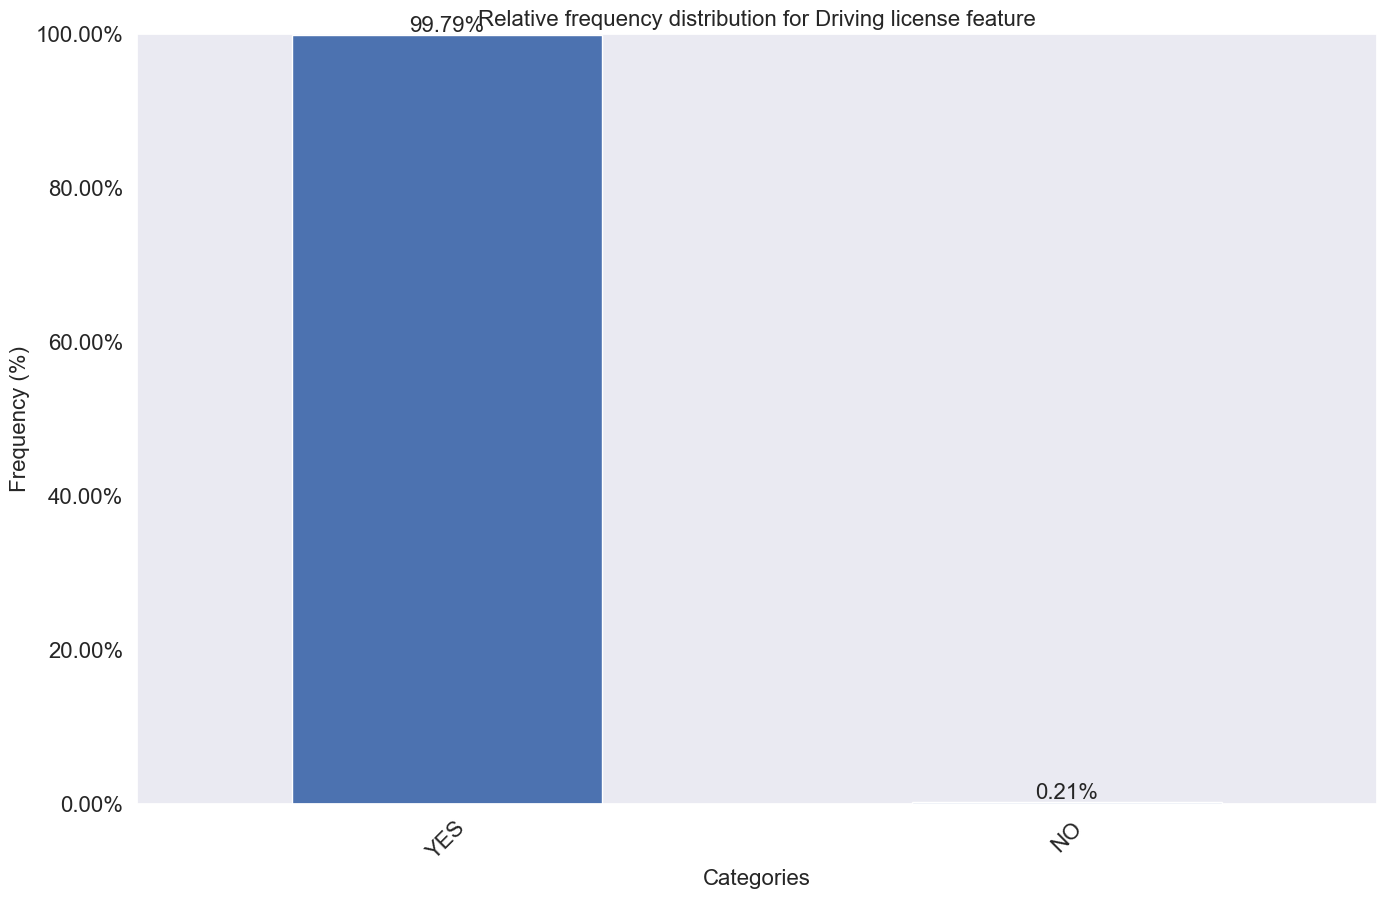

In [9]:
plot_frequency_distribution(df["Driving_License"].map({0:"NO", 1:"YES"}), "Driving license")

Notevole sbilanciamento tra chi possiede la patente e chi no. Dato utile per successive considerazioni.

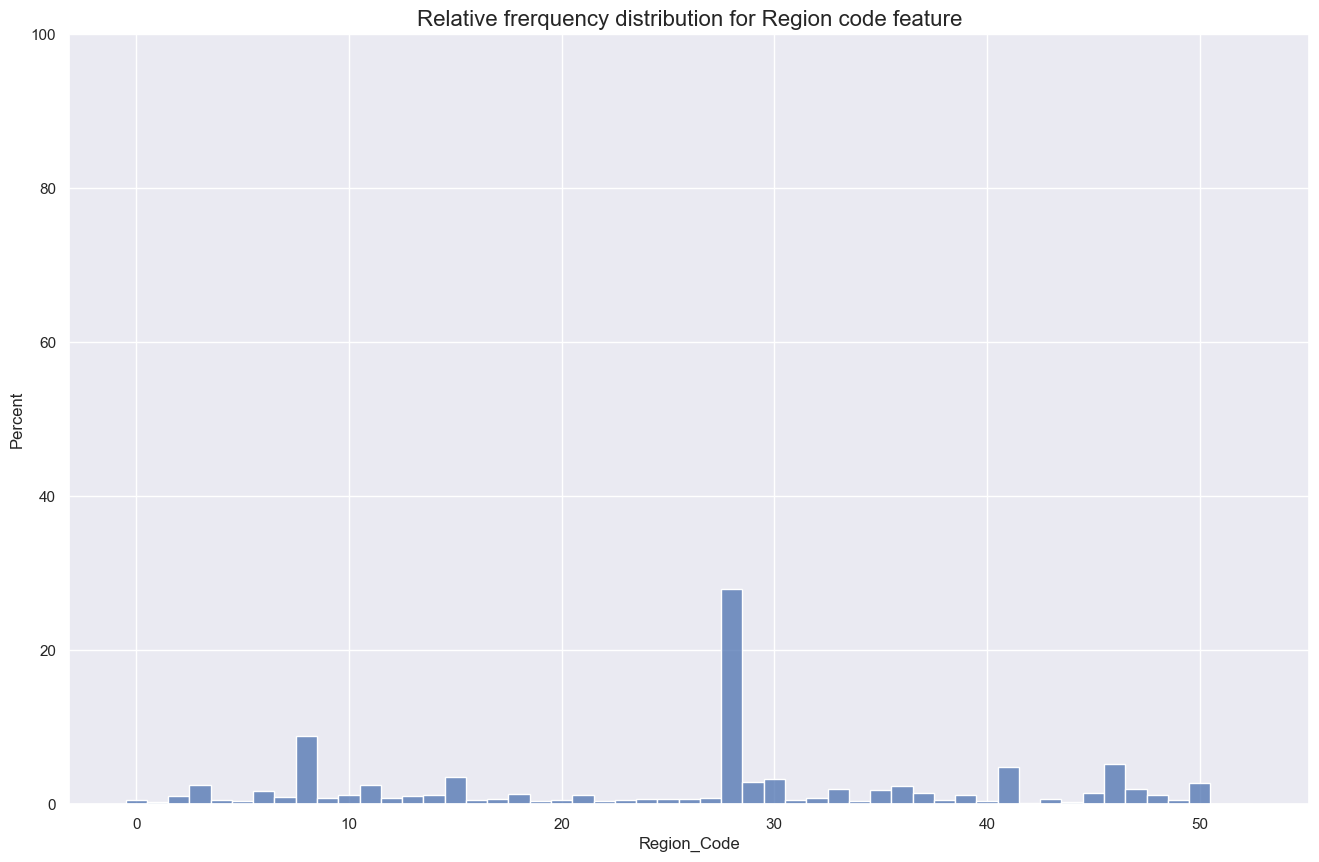

In [10]:
sns.histplot(x=df["Region_Code"], stat='percent',discrete=True)
plt.title("Relative frerquency distribution for Region code feature",
         fontsize=16)
plt.ylim((0,100))
plt.grid()
plt.show()

Previously_Insured
NO     54.178988
YES    45.821012
Name: proportion, dtype: float64


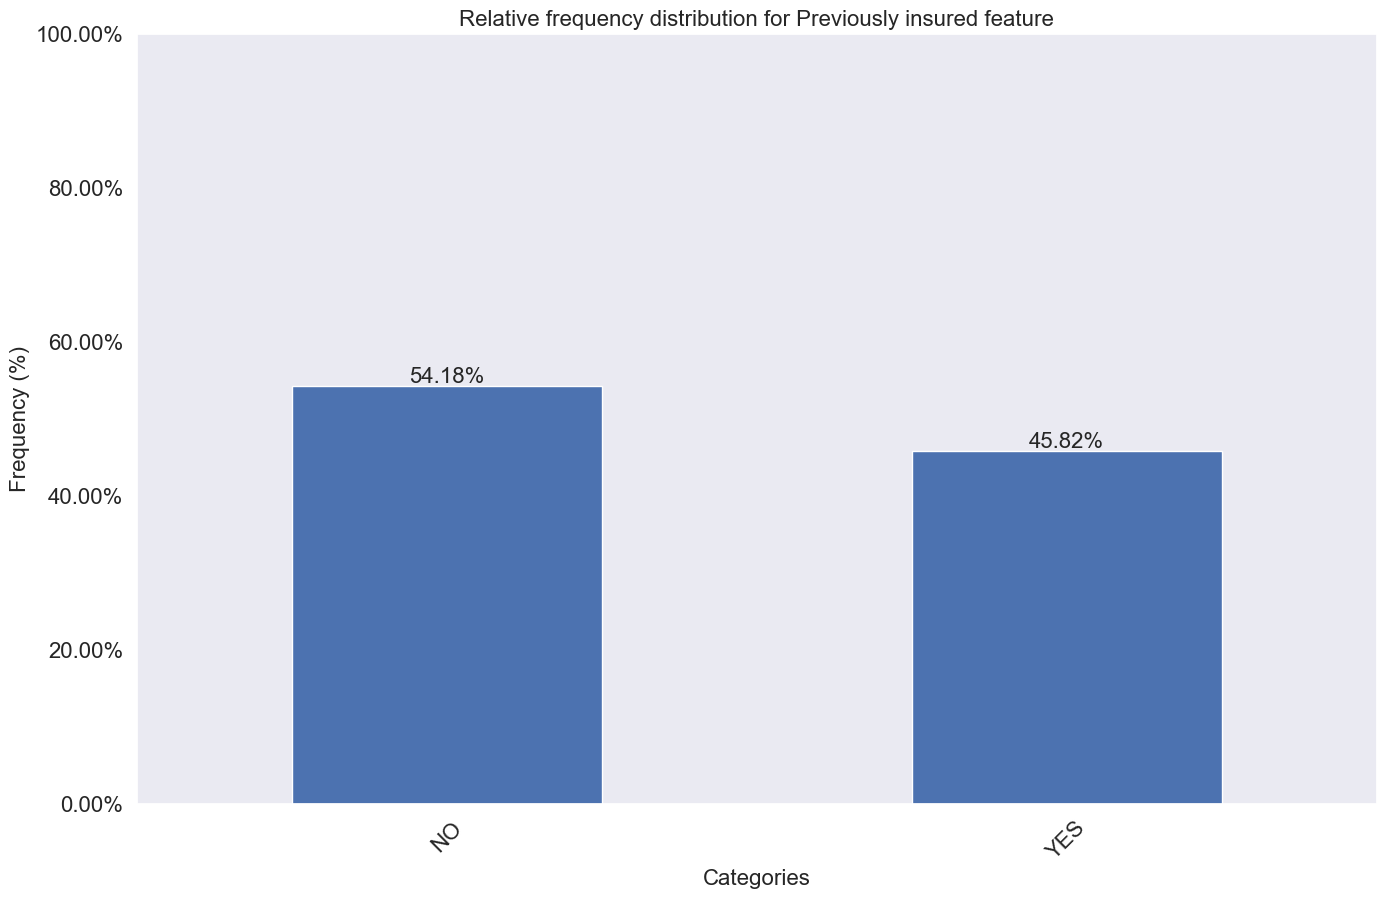

In [11]:
plot_frequency_distribution(df["Previously_Insured"].map({0:"NO",1:"YES"}), "Previously insured")

Categorie abbastanza bilanciate.

Vehicle_Age
1-2 Year     52.561341
< 1 Year     43.238549
> 2 Years     4.200111
Name: proportion, dtype: float64


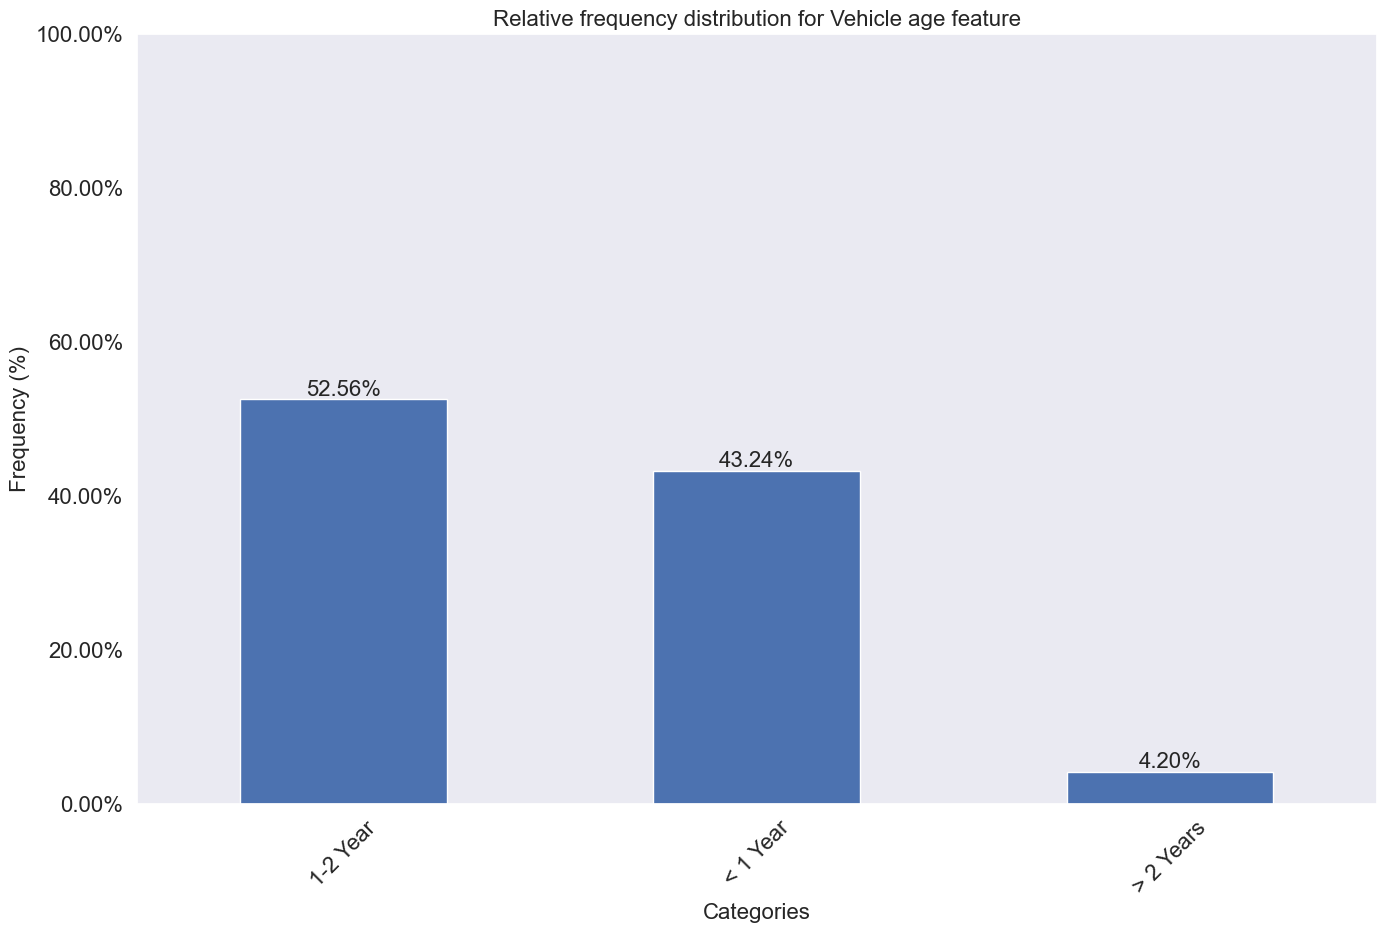

In [12]:
plot_frequency_distribution(df["Vehicle_Age"], "Vehicle age")

Le prime due categorie hanno una frequenza simile, molto bassa invece la frequenza "> 2 Years"

Vehicle_Damage
Yes    50.487656
No     49.512344
Name: proportion, dtype: float64


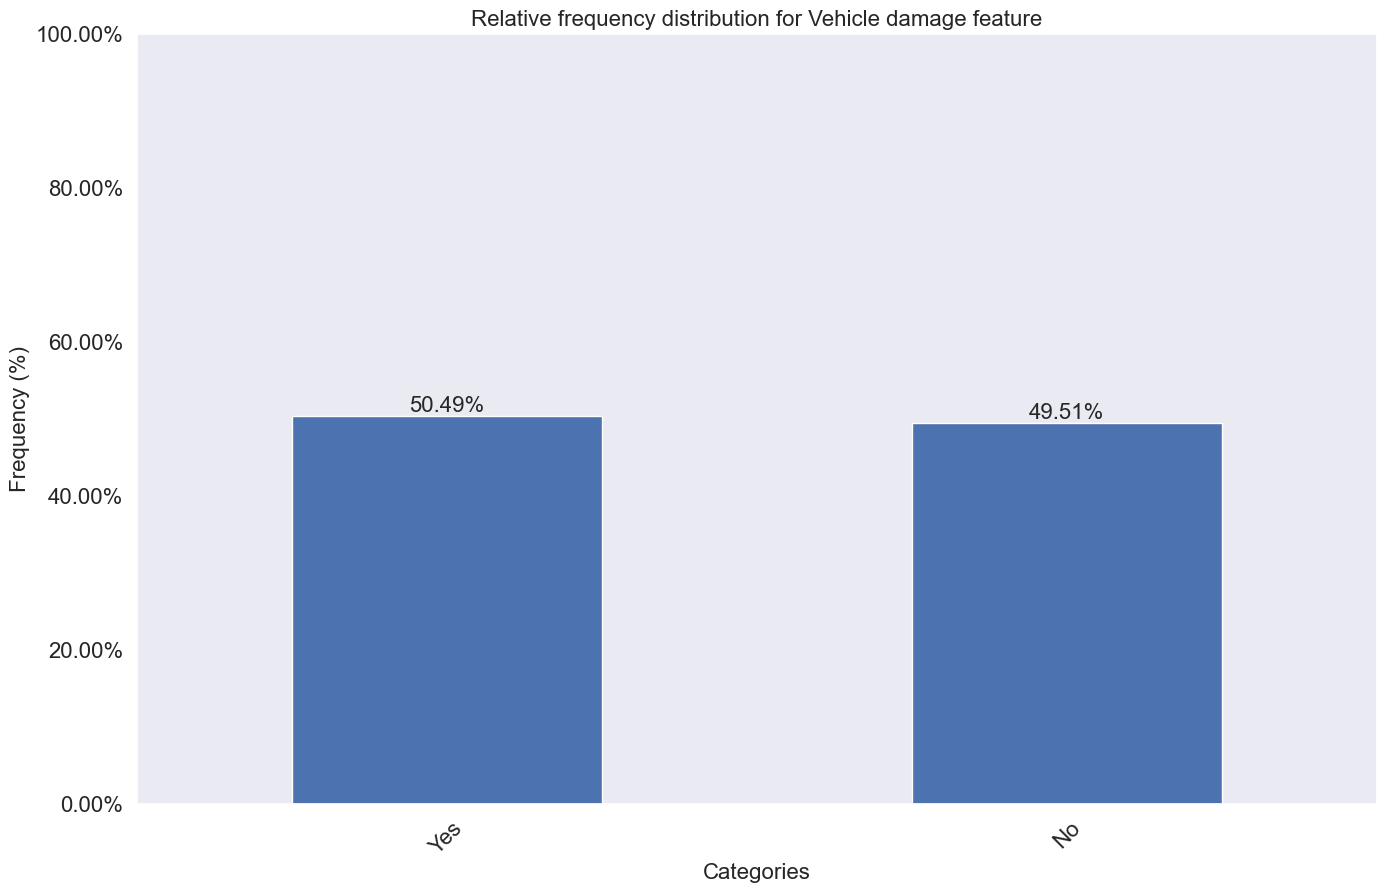

In [13]:
plot_frequency_distribution(df["Vehicle_Damage"], "Vehicle damage")

Categorie abbastanza bilanciate.

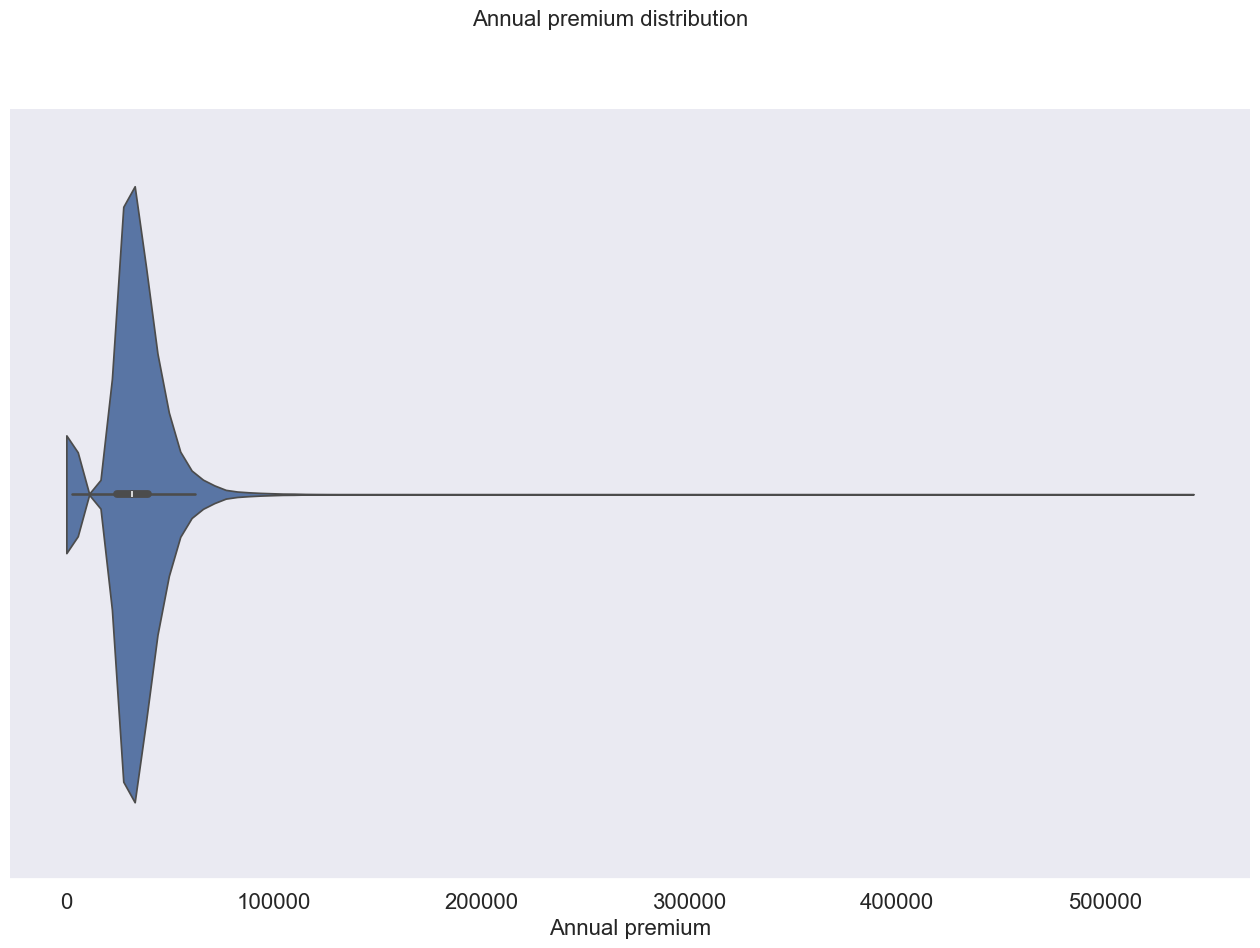

In [14]:
plot_quantitative_distribution(df["Annual_Premium"],'Annual premium')

Il grafico a violino ci mostra una distribuzione altamente asimmetrica. La maggior parte dei dati è distribuita vicino a valori molto bassi.

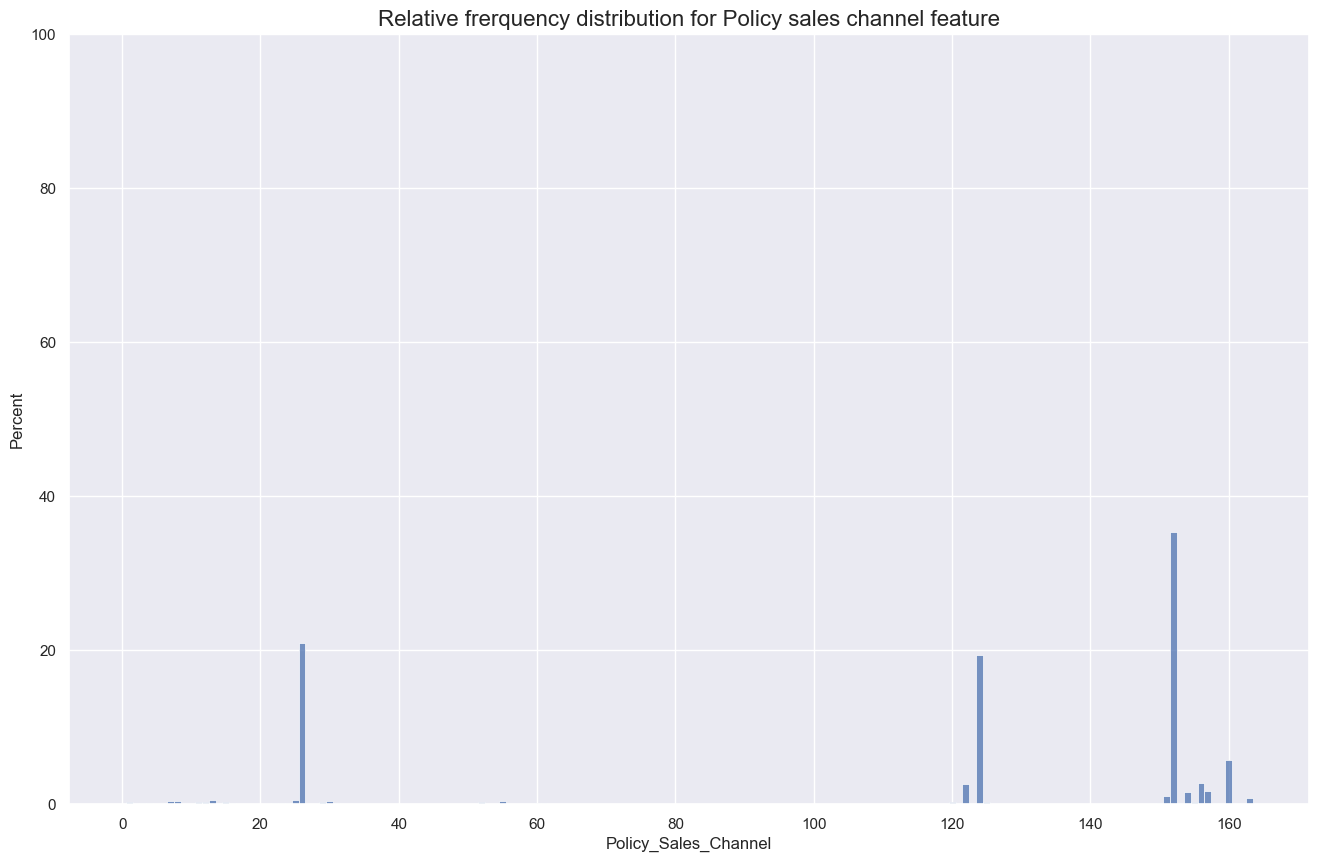

In [15]:
sns.histplot(x=df["Policy_Sales_Channel"], stat='percent',discrete=True)
plt.title("Relative frerquency distribution for Policy sales channel feature",
         fontsize=16)
plt.ylim((0,100))
plt.grid()
plt.show()

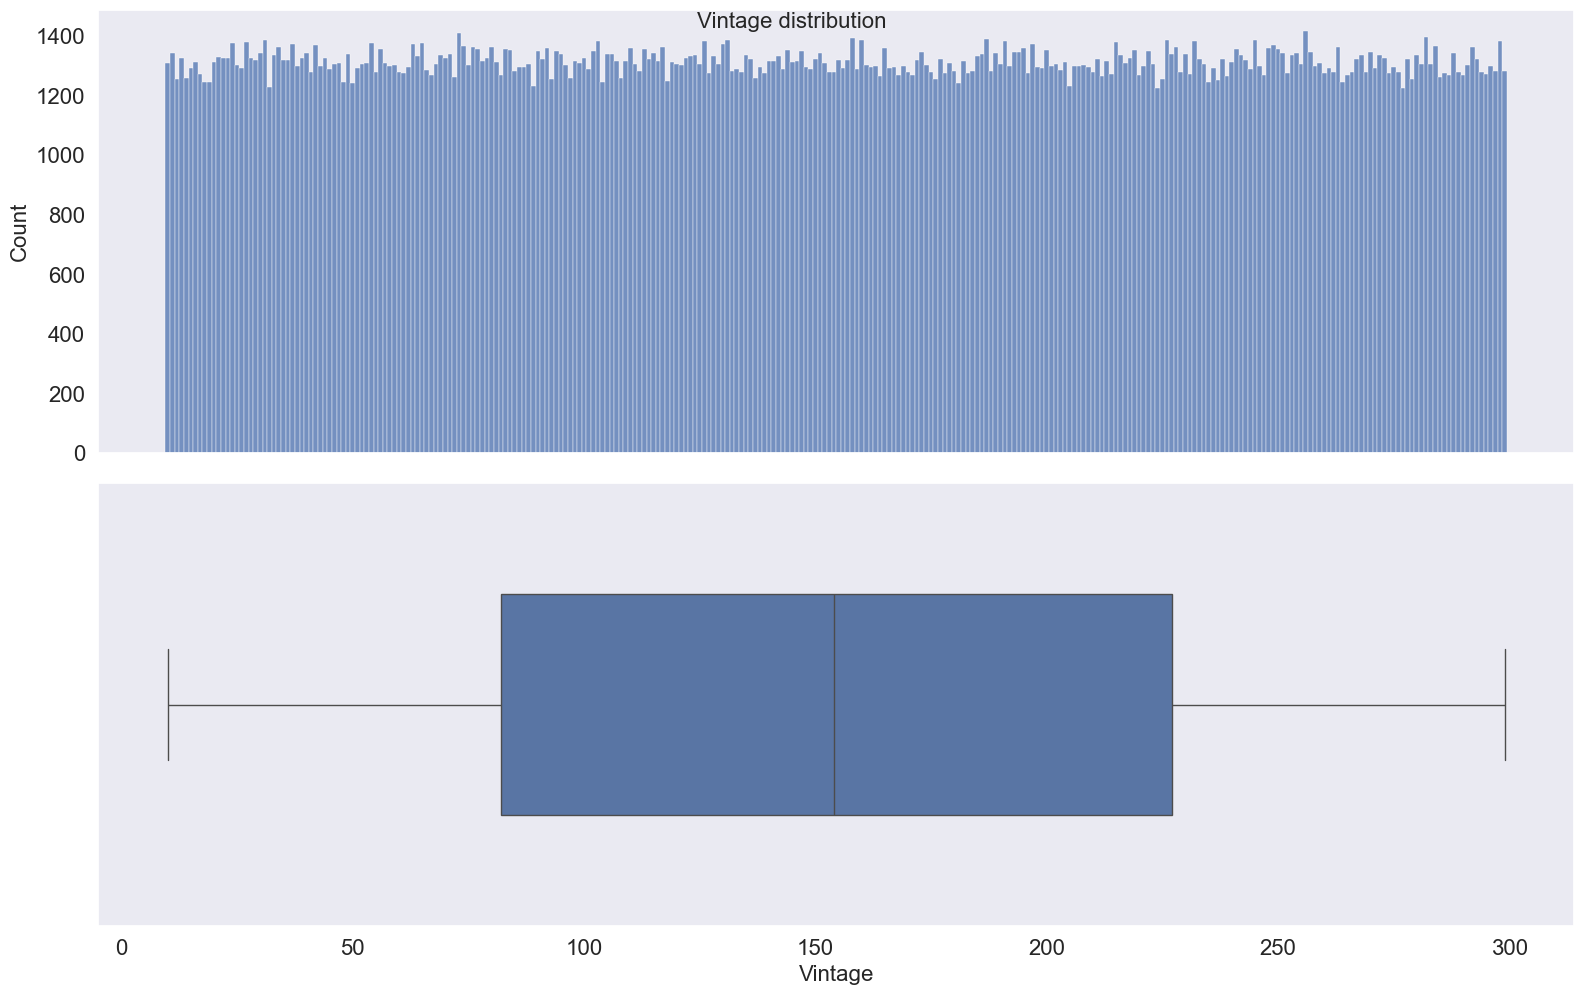

In [16]:
plot_quantitative_distribution(df["Vintage"],'Vintage',True)

Non ci sono considerazioni particolari da esporre per il precedente grafico. Distribuzione pressochè omogenea.

Response
Negative    87.743664
Positive    12.256336
Name: proportion, dtype: float64


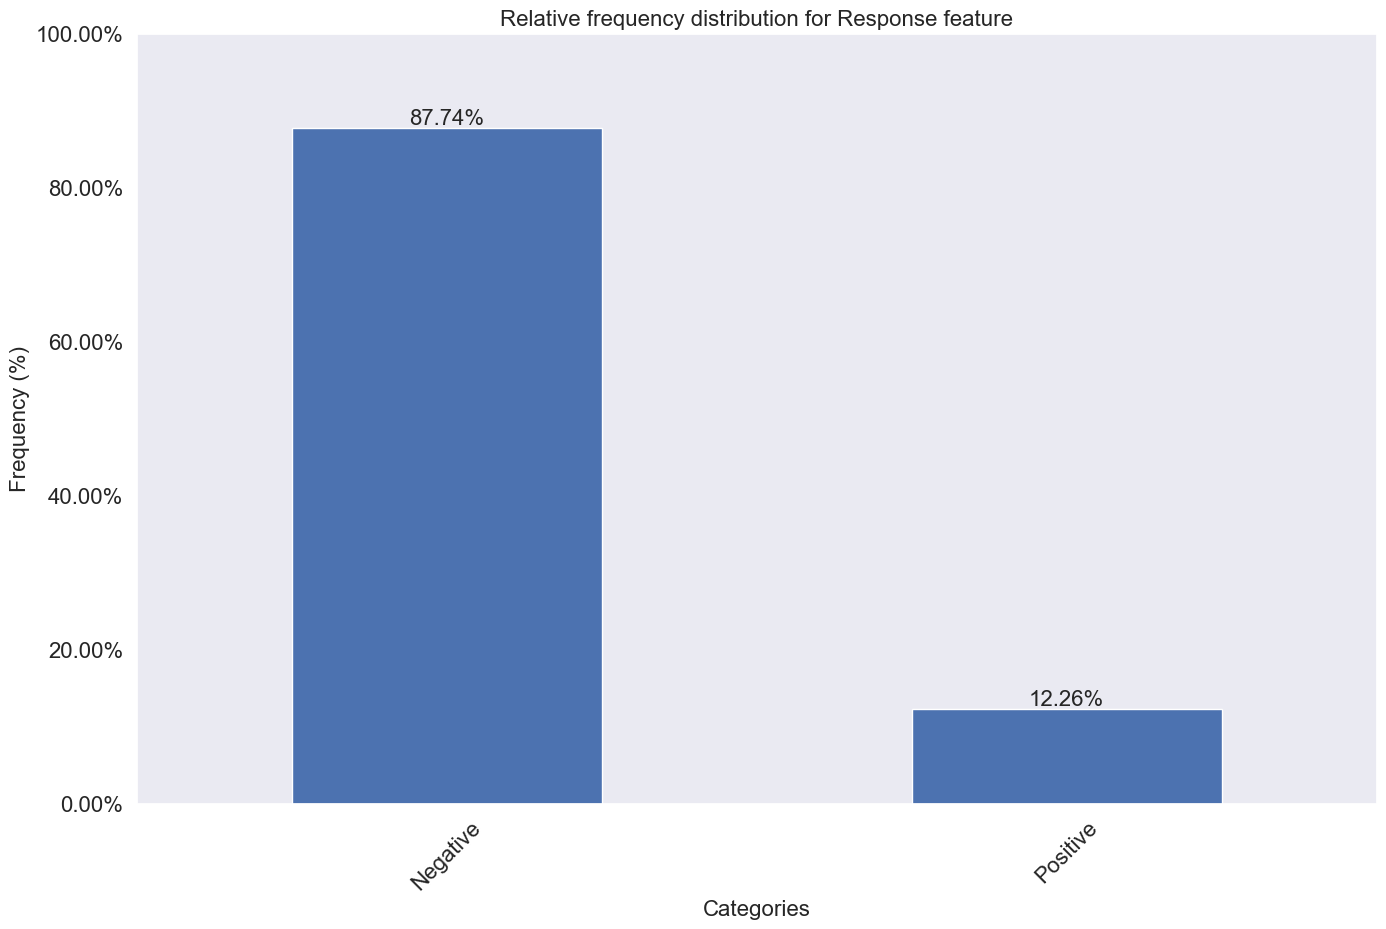

In [17]:
plot_frequency_distribution(df["Response"].map({0:"Negative",1:"Positive"}), "Response")

Sbilanciamento eccessivo, occorre rimediare a questa disparità.

Converto le variabili categoriche

In [18]:
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
vehicle_age_mapping = {'> 2 Years': 2, '1-2 Year': 1, '< 1 Year': 0}
df['Vehicle_Age'] = df['Vehicle_Age'].map(vehicle_age_mapping)
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'Yes': 1, 'No': 0})
print(df.head())

    Gender  Age  Driving_License  Region_Code  Previously_Insured  \
id                                                                  
1        1   44                1         28.0                   0   
2        1   76                1          3.0                   0   
3        1   47                1         28.0                   0   
4        1   21                1         11.0                   1   
5        0   29                1         41.0                   1   

    Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
id                                                                      
1             2               1         40454.0                  26.0   
2             1               0         33536.0                  26.0   
3             2               1         38294.0                  26.0   
4             0               0         28619.0                 152.0   
5             0               0         27496.0                 152.0   

    

Individuazione dati mancanti, elimina le righe che li contengono, secondo check di dati mancanti

In [19]:
print("Valori mancanti prima dell'eliminazione:", df.isnull().sum().sum())
df.dropna(inplace=True)
print("Valori mancanti dopo l'eliminazione:", df.isnull().sum().sum())

Valori mancanti prima dell'eliminazione: 0
Valori mancanti dopo l'eliminazione: 0


Analisi multivariata - Settings dei grafici

In [20]:
def plot_multi_hist(df,feature_name,target_name):

    FONT_SIZE = 16
    sns.histplot(data = df, x = feature_name,
                 hue = target_name, multiple="dodge")
    plt.yticks(fontsize = FONT_SIZE)
    plt.xticks(fontsize = FONT_SIZE)
    plt.xlabel(feature_name, fontsize = FONT_SIZE)
    plt.ylabel("Count", fontsize = FONT_SIZE)
    plt.title(f"Conditional histogram for {feature_name}")
    plt.show()

In [21]:
def chi_test_feature_target(feature, target, categorical=False, nbins=10):
    if(categorical):
        feature_discr = feature
    else:
        feature_discr = pd.cut(feature,nbins)
    cross_table = pd.crosstab(feature_discr, target)
    print(chi2_contingency(cross_table))


In [22]:
data_clean = df.drop("Driving_License",axis=1)

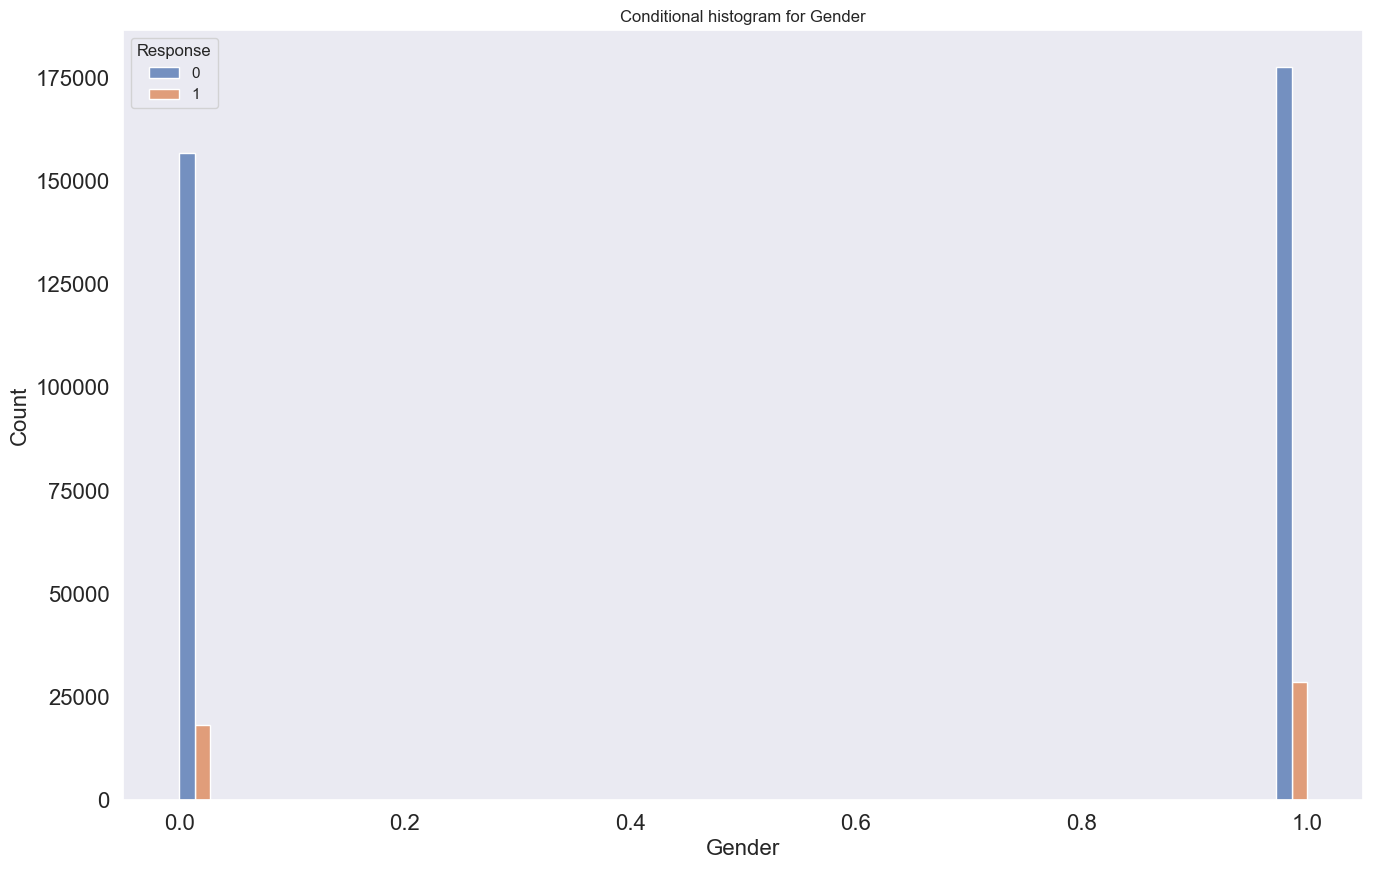

Chi2ContingencyResult(statistic=1047.7077577887574, pvalue=7.665800628415621e-230, dof=1, expected_freq=array([[153568.9605336,  21451.0394664],
       [180830.0394664,  25258.9605336]]))


In [23]:
plot_multi_hist(data_clean,"Gender","Response")
chi_test_feature_target(data_clean["Gender"], data_clean["Response"],True)

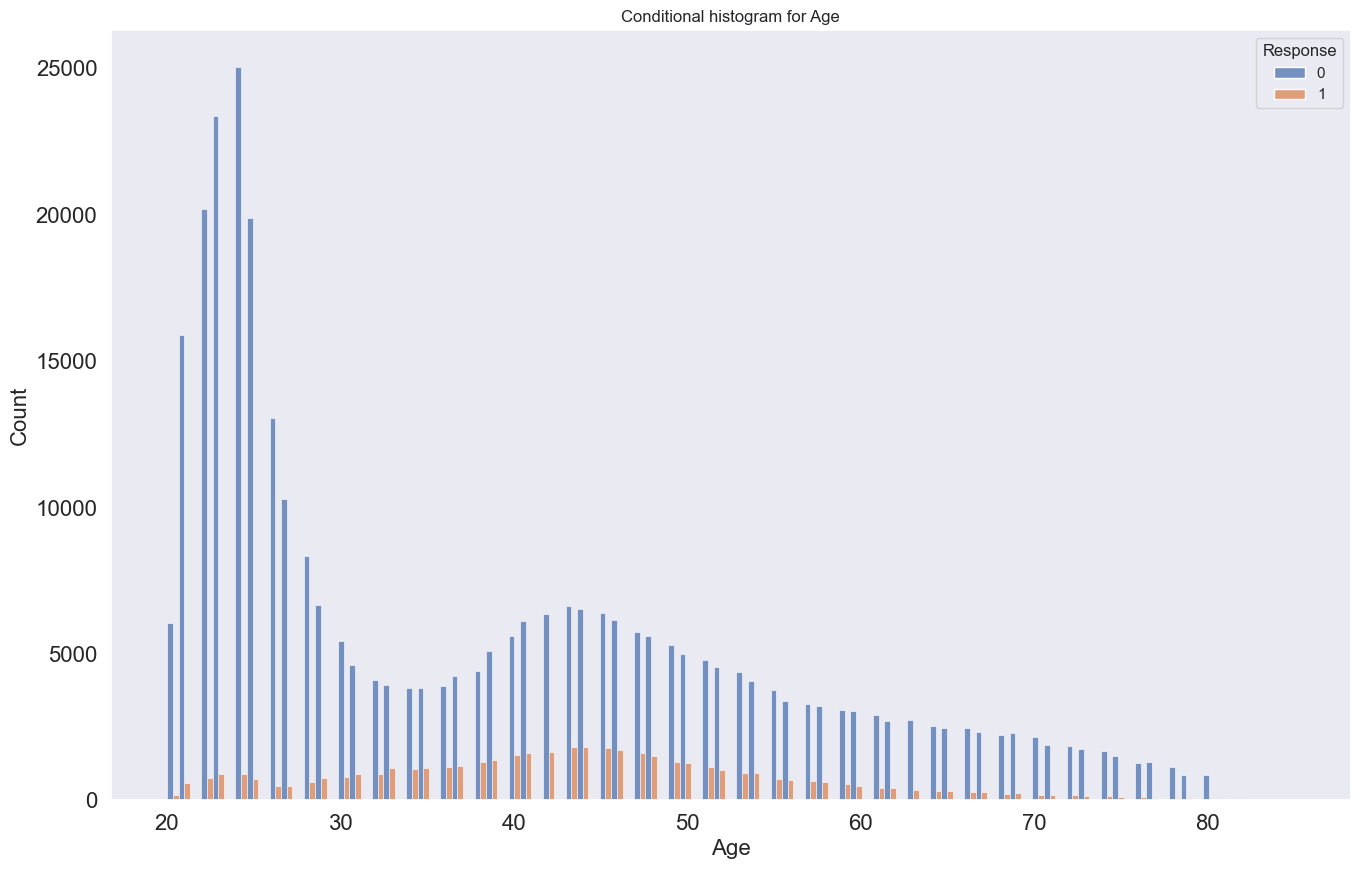

Chi2ContingencyResult(statistic=19563.10715380452, pvalue=0.0, dof=9, expected_freq=array([[112346.98723987,  15693.01276013],
       [ 42942.62654254,   5998.37345746],
       [ 28494.75484704,   3980.24515296],
       [ 48932.00903941,   6834.99096059],
       [ 34085.78110987,   4761.21889013],
       [ 26556.49731179,   3709.50268821],
       [ 16411.57489327,   2292.42510673],
       [ 14700.57344749,   2053.42655251],
       [  8214.56181302,   1147.43818698],
       [  1713.6337557 ,    239.3662443 ]]))


In [24]:
plot_multi_hist(data_clean,"Age","Response")
chi_test_feature_target(data_clean["Age"], data_clean["Response"], False)

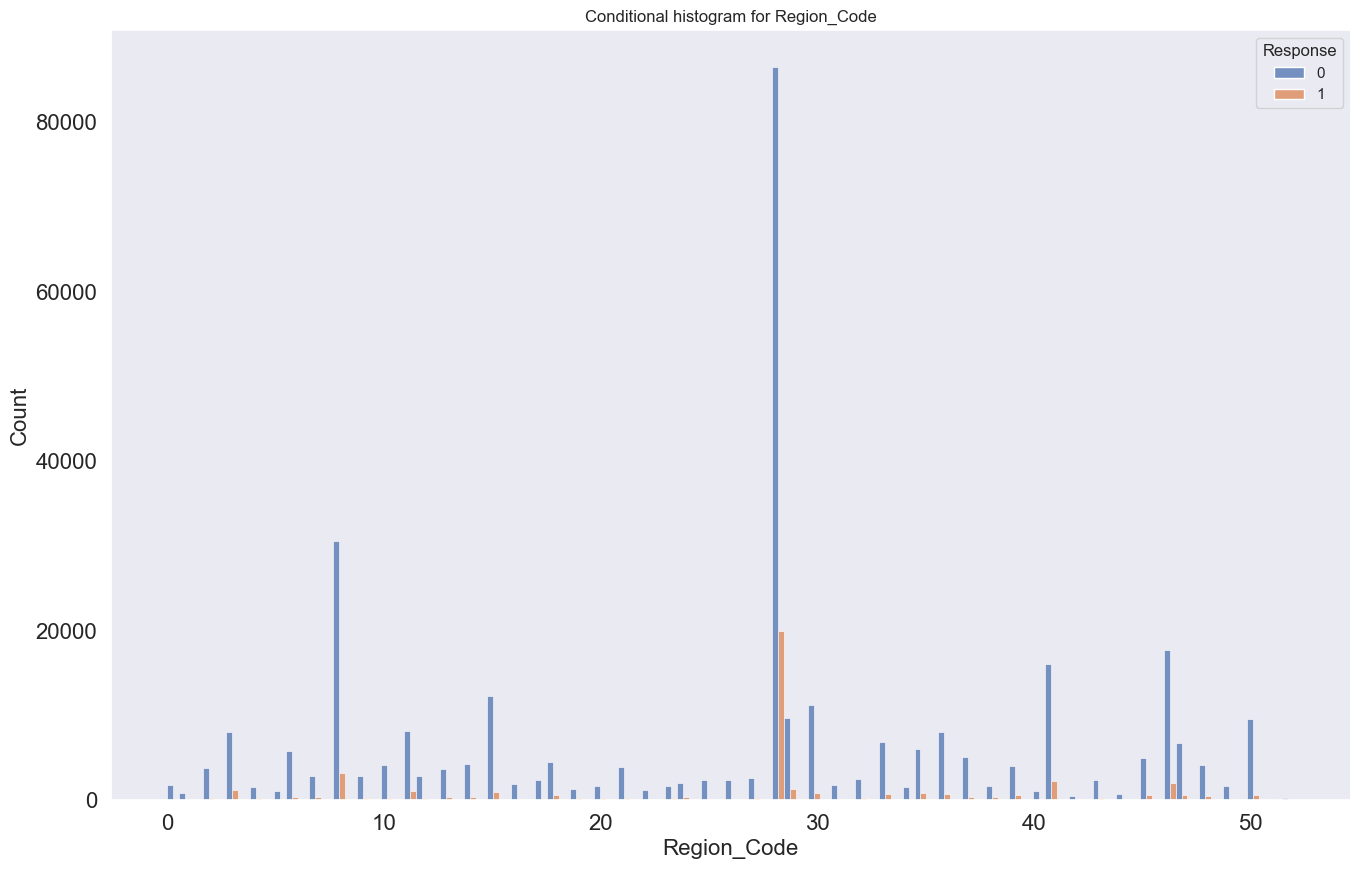

Chi2ContingencyResult(statistic=7267.842468803051, pvalue=0.0, dof=52, expected_freq=array([[1.77329945e+03, 2.47700553e+02],
       [8.84456132e+02, 1.23543868e+02],
       [3.54308915e+03, 4.94910852e+02],
       [8.11716635e+03, 1.13383365e+03],
       [1.58026339e+03, 2.20736613e+02],
       [1.12224146e+03, 1.56758539e+02],
       [5.51030209e+03, 7.69697908e+02],
       [2.87711474e+03, 4.01885261e+02],
       [2.97249210e+04, 4.15207899e+03],
       [2.72093102e+03, 3.80068983e+02],
       [3.83790786e+03, 5.36092142e+02],
       [8.10049505e+03, 1.13150495e+03],
       [2.80604237e+03, 3.91957629e+02],
       [3.54133427e+03, 4.94665726e+02],
       [4.10464860e+03, 5.73351403e+02],
       [1.16769268e+04, 1.63107321e+03],
       [1.76101533e+03, 2.45984666e+02],
       [2.29625168e+03, 3.20748316e+02],
       [4.52143100e+03, 6.31569000e+02],
       [1.34686524e+03, 1.88134759e+02],
       [1.69783990e+03, 2.37160104e+02],
       [3.74314470e+03, 5.22855299e+02],
       [1.148

In [25]:
plot_multi_hist(data_clean,"Region_Code","Response")
chi_test_feature_target(data_clean["Region_Code"],data_clean["Response"],True)

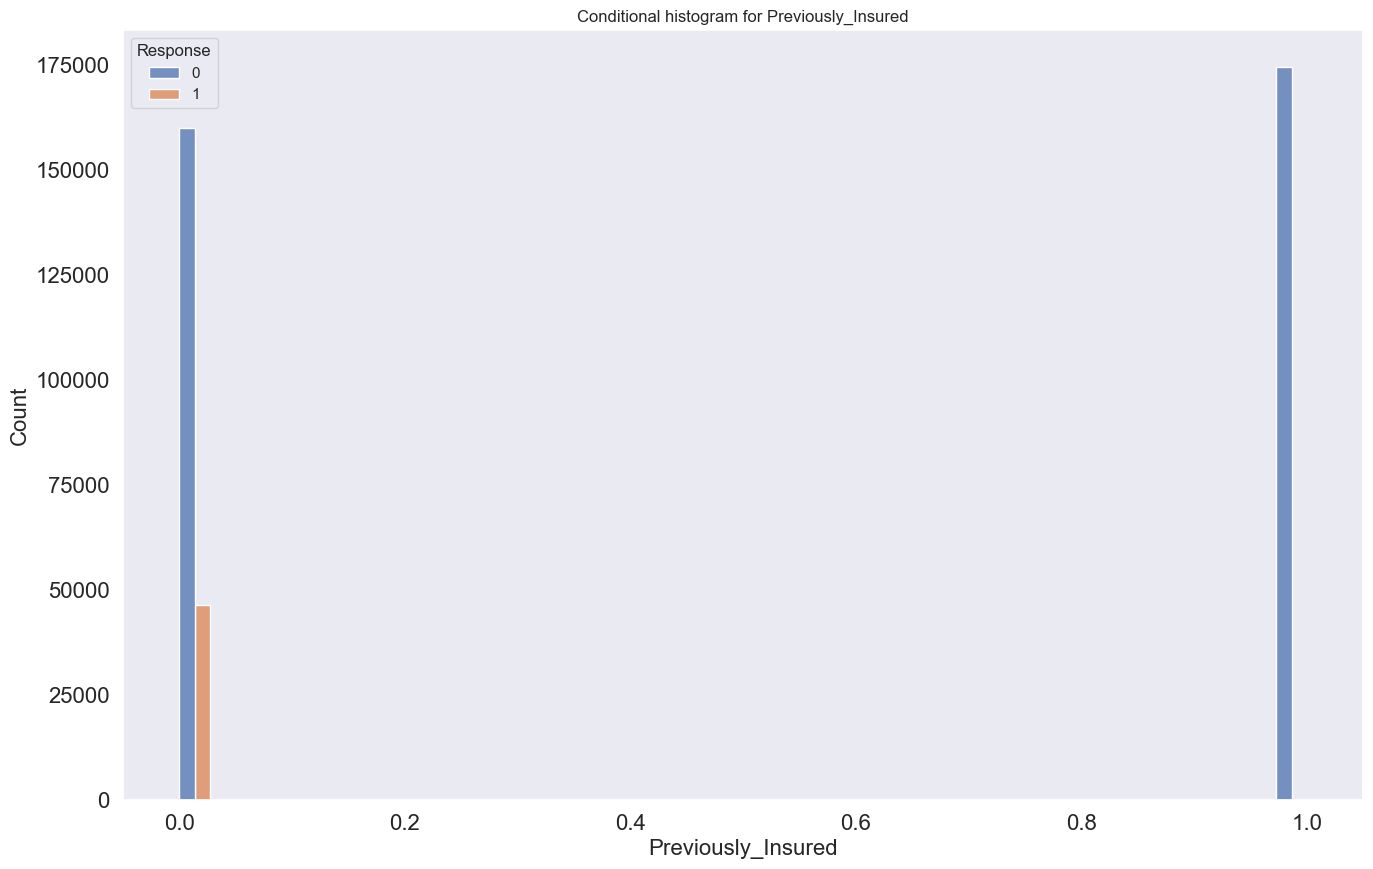

Chi2ContingencyResult(statistic=44357.96472219977, pvalue=0.0, dof=1, expected_freq=array([[181173.99462883,  25307.00537117],
       [153225.00537117,  21402.99462883]]))


In [26]:
plot_multi_hist(data_clean,"Previously_Insured","Response")
chi_test_feature_target(data_clean["Previously_Insured"],data_clean["Response"],True)

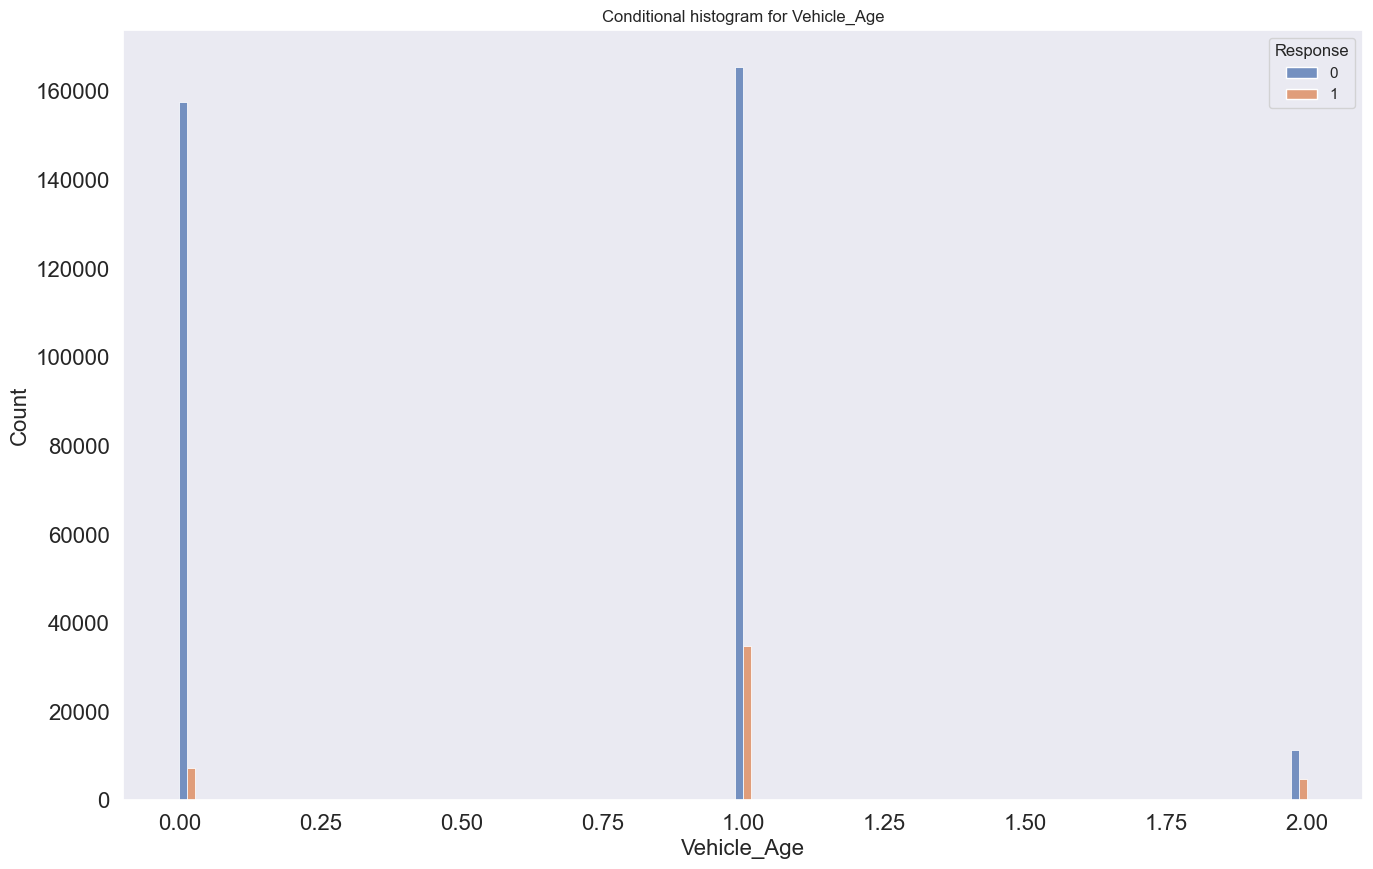

Chi2ContingencyResult(statistic=18771.889904151052, pvalue=0.0, dof=2, expected_freq=array([[144589.27397149,  20196.72602851],
       [175764.59775025,  24551.40224975],
       [ 14045.12827826,   1961.87172174]]))


In [27]:
plot_multi_hist(data_clean,"Vehicle_Age","Response")
chi_test_feature_target(data_clean["Vehicle_Age"],data_clean["Response"],True)

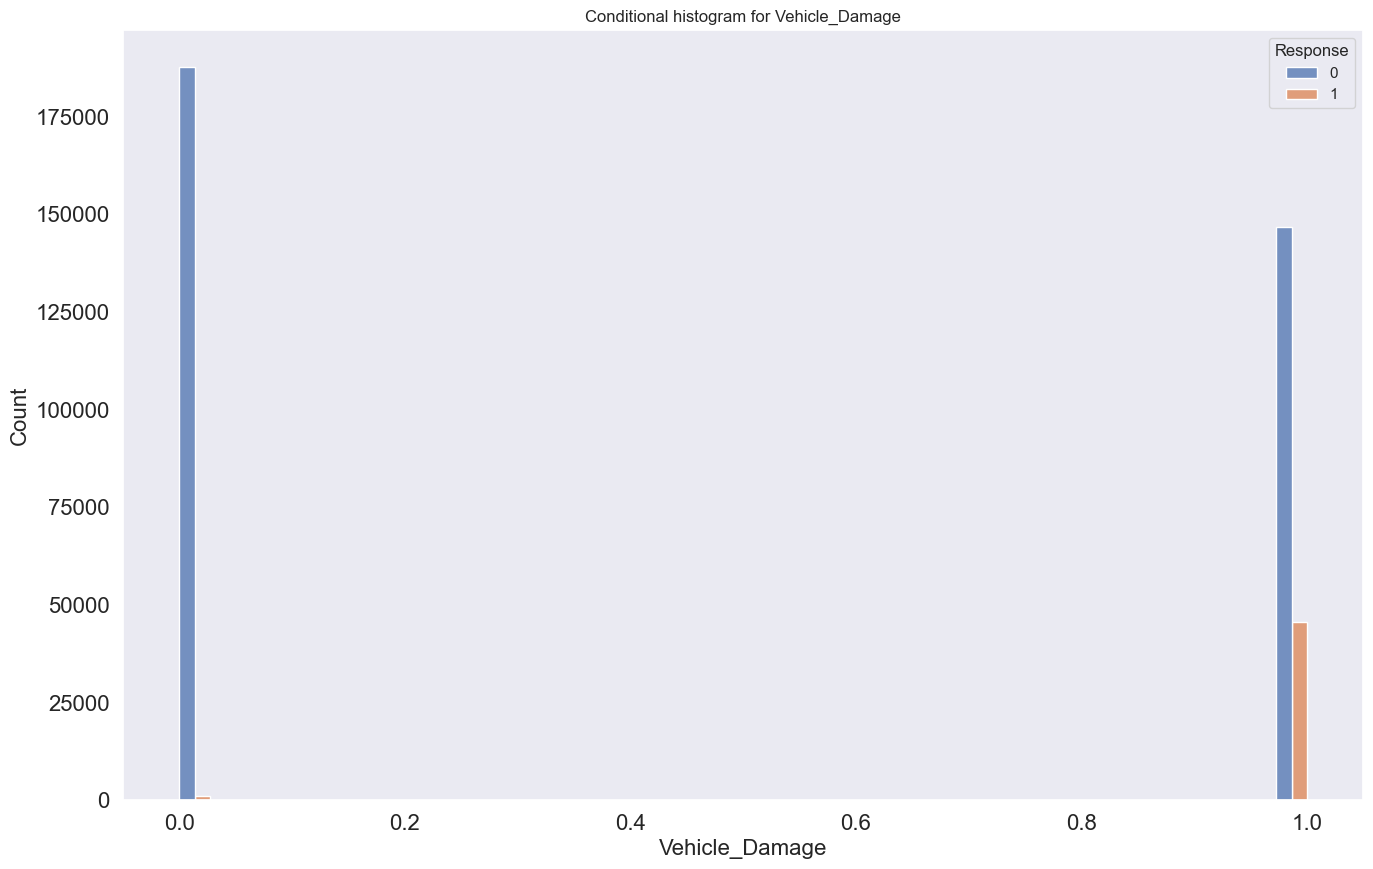

Chi2ContingencyResult(statistic=47864.76180117493, pvalue=0.0, dof=1, expected_freq=array([[165568.78400668,  23127.21599332],
       [168830.21599332,  23582.78400668]]))


In [28]:
plot_multi_hist(data_clean,"Vehicle_Damage","Response")
chi_test_feature_target(data_clean["Vehicle_Damage"],data_clean["Response"],True)

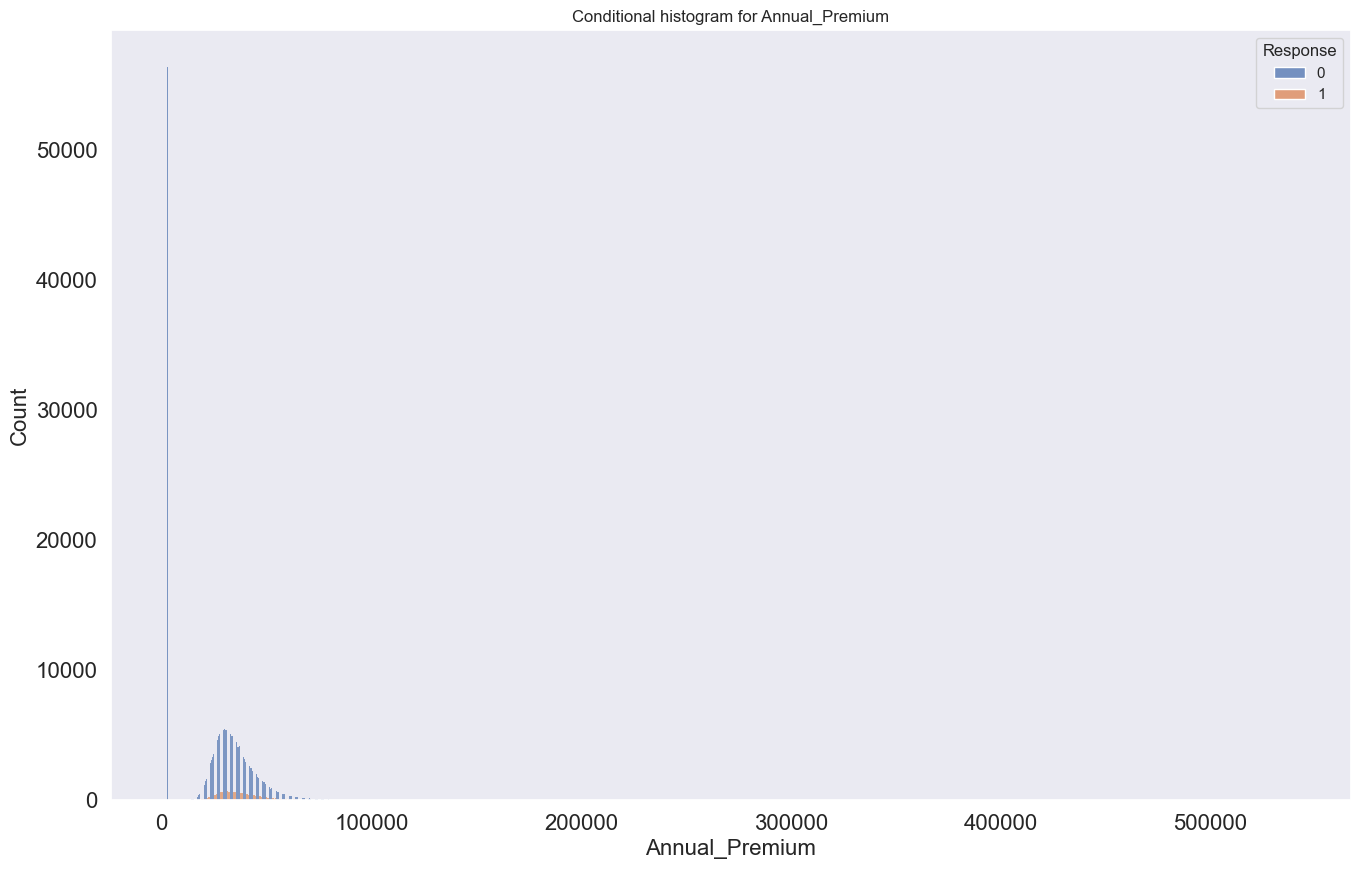

Chi2ContingencyResult(statistic=160.41484160679707, pvalue=6.0896465698109896e-30, dof=9, expected_freq=array([[3.19445725e+05, 4.46212752e+04],
       [1.45303507e+04, 2.02964926e+03],
       [2.80779724e+02, 3.92202756e+01],
       [5.35236350e+01, 7.47636503e+00],
       [2.98328457e+01, 4.16715428e+00],
       [2.72005358e+01, 3.79946420e+00],
       [1.84261694e+01, 2.57383058e+00],
       [3.50974656e+00, 4.90253445e-01],
       [3.50974656e+00, 4.90253445e-01],
       [6.14205647e+00, 8.57943528e-01]]))


In [29]:
plot_multi_hist(data_clean,"Annual_Premium","Response")
chi_test_feature_target(data_clean["Annual_Premium"],data_clean["Response"],False)

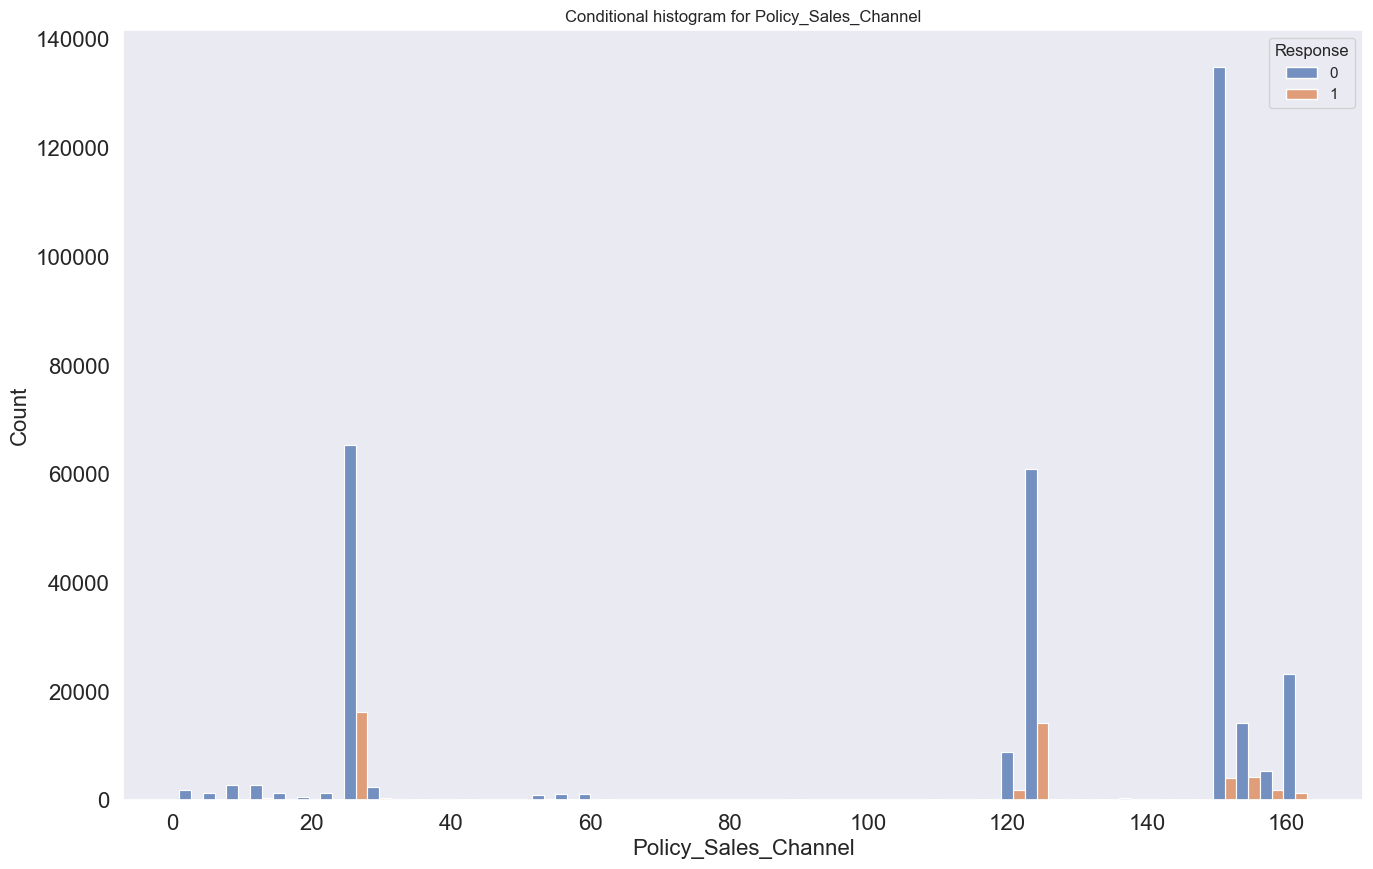

Chi2ContingencyResult(statistic=14061.497321524184, pvalue=0.0, dof=9, expected_freq=array([[1.01422901e+04, 1.41670989e+03],
       [7.59245924e+04, 1.06054076e+04],
       [6.24734887e+02, 8.72651131e+01],
       [3.45710036e+03, 4.82899643e+02],
       [1.07924707e+02, 1.50752934e+01],
       [3.93969051e+02, 5.50309492e+01],
       [5.54539956e+02, 7.74600442e+01],
       [7.58008738e+04, 1.05881262e+04],
       [9.98522895e+02, 1.39477105e+02],
       [1.66394452e+05, 2.32425481e+04]]))


In [30]:
plot_multi_hist(data_clean,"Policy_Sales_Channel","Response")
chi_test_feature_target(data_clean["Policy_Sales_Channel"],data_clean["Response"],False)

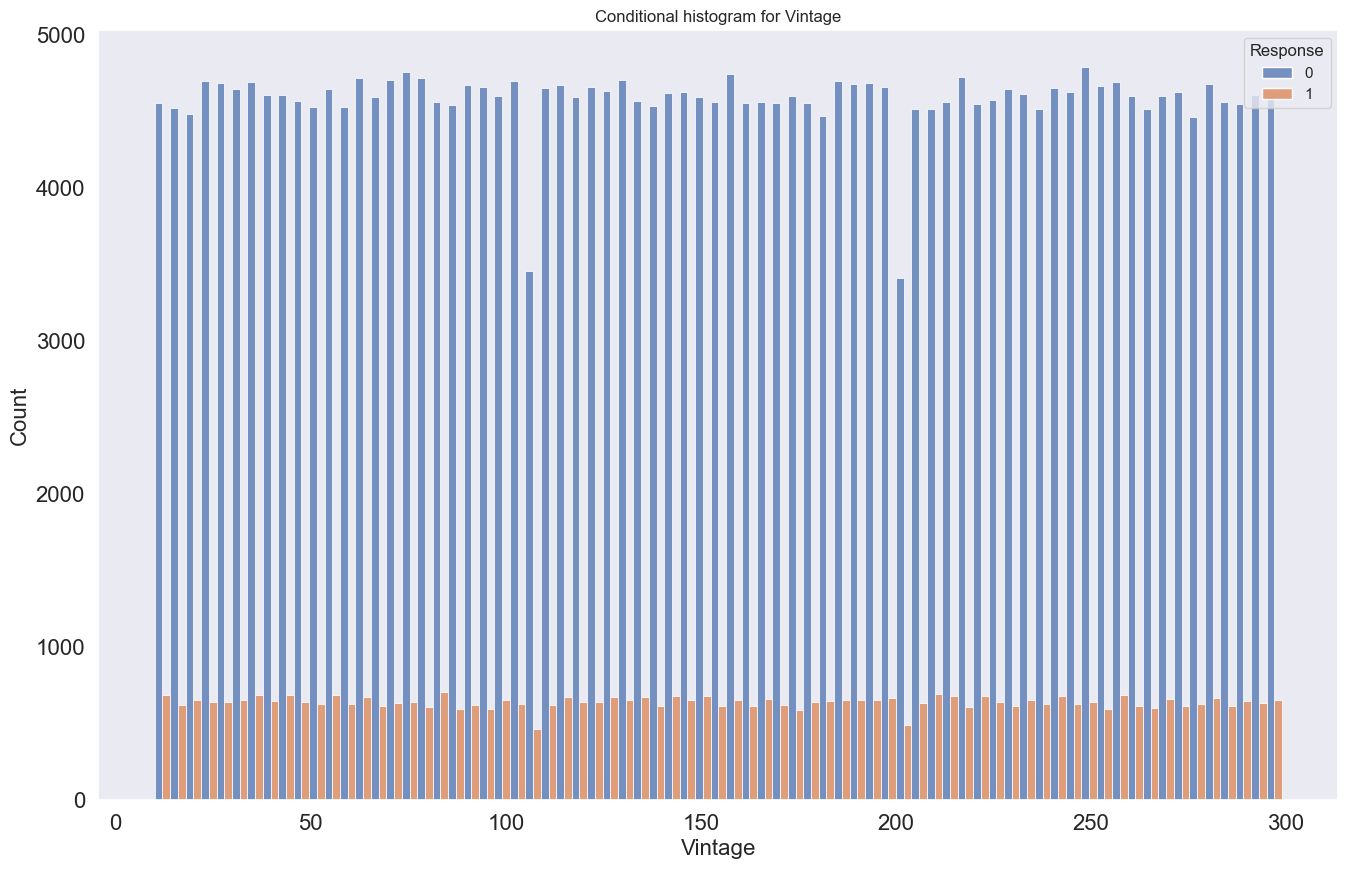

Chi2ContingencyResult(statistic=13.5818225585614, pvalue=0.13799749942299142, dof=9, expected_freq=array([[33486.49188552,  4677.50811448],
       [33374.17999575,  4661.82000425],
       [33690.05718574,  4705.94281426],
       [33529.48628083,  4683.51371917],
       [33475.08520922,  4675.91479078],
       [33164.47263906,  4632.52736094],
       [33474.20777258,  4675.79222742],
       [33412.78720786,  4667.21279214],
       [33589.15197227,  4691.84802773],
       [33203.07985117,  4637.92014883]]))


In [31]:
plot_multi_hist(data_clean,"Vintage","Response")
chi_test_feature_target(data_clean["Vintage"],data_clean["Response"])

Il test del chi-quadrato per la viariabile Vintage non mostra un'associazione significativa tra le variabili (p-value > 0.05). Pertanto, non vi è evidenza sufficiente per affermare che esista una relazione tra di esse, e l'ipotesi nulla di indipendenza non può essere respinta.
Per tutte le altre variabili, il test del chi-quadrato indica una differenza altamente significativa tra le categorie delle due variabili considerate. Questo risultato suggerisce che c'è una forte associazione tra le variabili, il che implica che le due variabili non sono indipendenti.

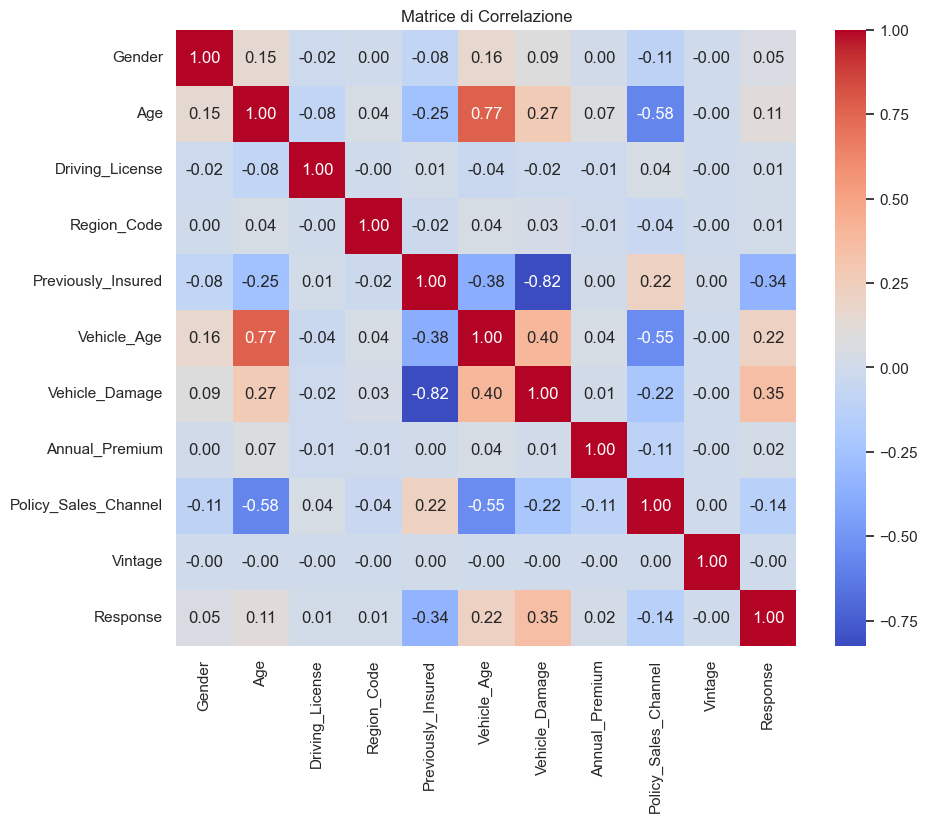

In [32]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Matrice di Correlazione')
plt.show()

- Age e Vehicle_Age: Presentano una forte correlazione positiva (0.77), suggerendo che le persone più anziane tendono a possedere veicoli più vecchi.
- Previously_Insured e Vehicle_Damage: Presentano una forte correlazione negativa (-0.82), il che potrebbe indicare che chi è già assicurato ha meno probabilità di aver subìto danni al veicolo.
- Policy_Sales_Channel e Age: Presentano una correlazione negativa significativa (-0.58), suggerendo che i canali di vendita delle polizze potrebbero variare notevolmente in base all'età del cliente.
- Response e Vehicle_Damage: C'è una correlazione positiva moderata (0.35), suggerendo che le persone che hanno subìto danni al veicolo potrebbero essere più inclini a rispondere positivamente (ad esempio, acquistare una polizza assicurativa).
- Previously_Insured e Response: Presentano una correlazione negativa (-0.34), suggerendo che chi è già assicurato potrebbe essere meno propenso a rispondere positivamente.

Age e Vehicle_Age, Previously_Insured e Vehicle_Damage sono le due coppie con una forte correlazione. Analizzando la correlazione che hanno con la variabile Target, decido di togliere Previously_Insured e Age.

Calcolo del conteggio e della percentuale per la variabile target 'Response'

In [33]:
print(data_clean['Response'].value_counts(normalize=True) * 100)

Response
0    87.743664
1    12.256336
Name: proportion, dtype: float64


In [34]:
data_clean.drop("Previously_Insured",axis=1,inplace=True)
data_clean.drop("Age",axis=1,inplace=True)

In [35]:
X = data_clean.drop("Response",axis=1)
y = data_clean["Response"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

Correzione segli sbilanciamenti con l'Oversampling. Lo sbilanciamento notevole tra la classe Negative e Positive può portare ad un problema di overfitting.

In [36]:
smote = SMOTENC(categorical_features=["Region_Code","Vehicle_Age",
                                         "Vehicle_Damage","Policy_Sales_Channel"])
X_train_smote,y_train_smote = smote.fit_resample(X_train,
                                           y_train)

In [118]:
y_train_smote.value_counts()

Response
0    234124
1    234124
Name: count, dtype: int64

In [37]:
X_train = X_train_smote
y_train = y_train_smote

MODELLO PREDITTIVO: Regressione Logistica

In [38]:
nominal_features = ["Region_Code", "Policy_Sales_Channel"]
continuous_ordinal_features = ["Annual_Premium", "Vehicle_Age"]

preprocessor = ColumnTransformer(
    transformers=[
        # Applicare OneHotEncoder alle variabili categoriali nominali
        ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), nominal_features),
        # Applicare StandardScaler alle variabili continue/ordinali
        ("scaler", StandardScaler(), continuous_ordinal_features)
    ],
    remainder="passthrough"
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [39]:
model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Previsione sul test set

In [40]:
y_pred = model.predict(X_test)

In [41]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

Metriche per la classificazione

In [42]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

Stampa delle metriche

In [43]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.6949174778935215
Precision: 0.25951827739308475
Recall: 0.8072849577787319
F1 Score: 0.3927719652525112
ROC AUC Score: 0.7919490747124363


Il modello ha un alto Recall e un buon punteggio ROC AUC, indicando che è efficace nell'identificare i casi positivi. La bassa precisione e il basso F1 score suggeriscono un problema significativo con i falsi positivi. Il modello potrebbe prevedere troppi positivi che in realtà sono negativi.

Matrice di confusione

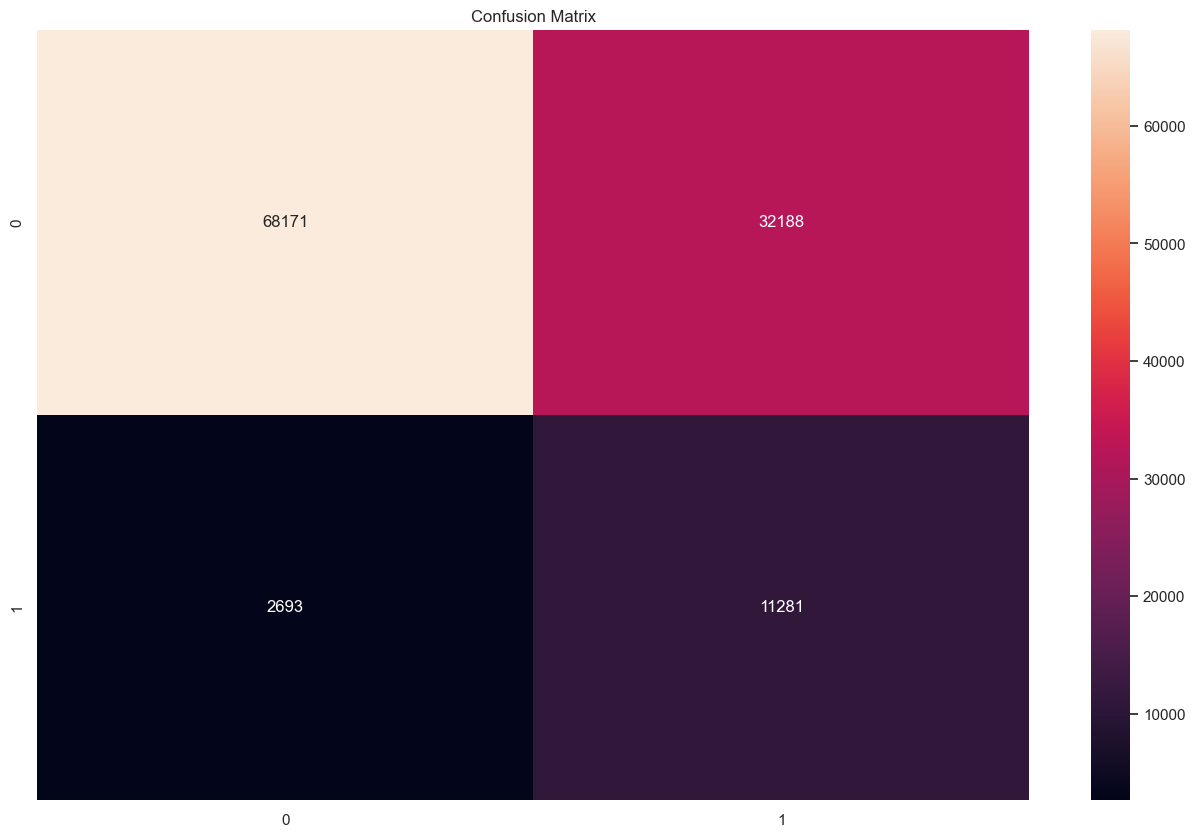

In [44]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

Calcolo e tracciamento della curva ROC 

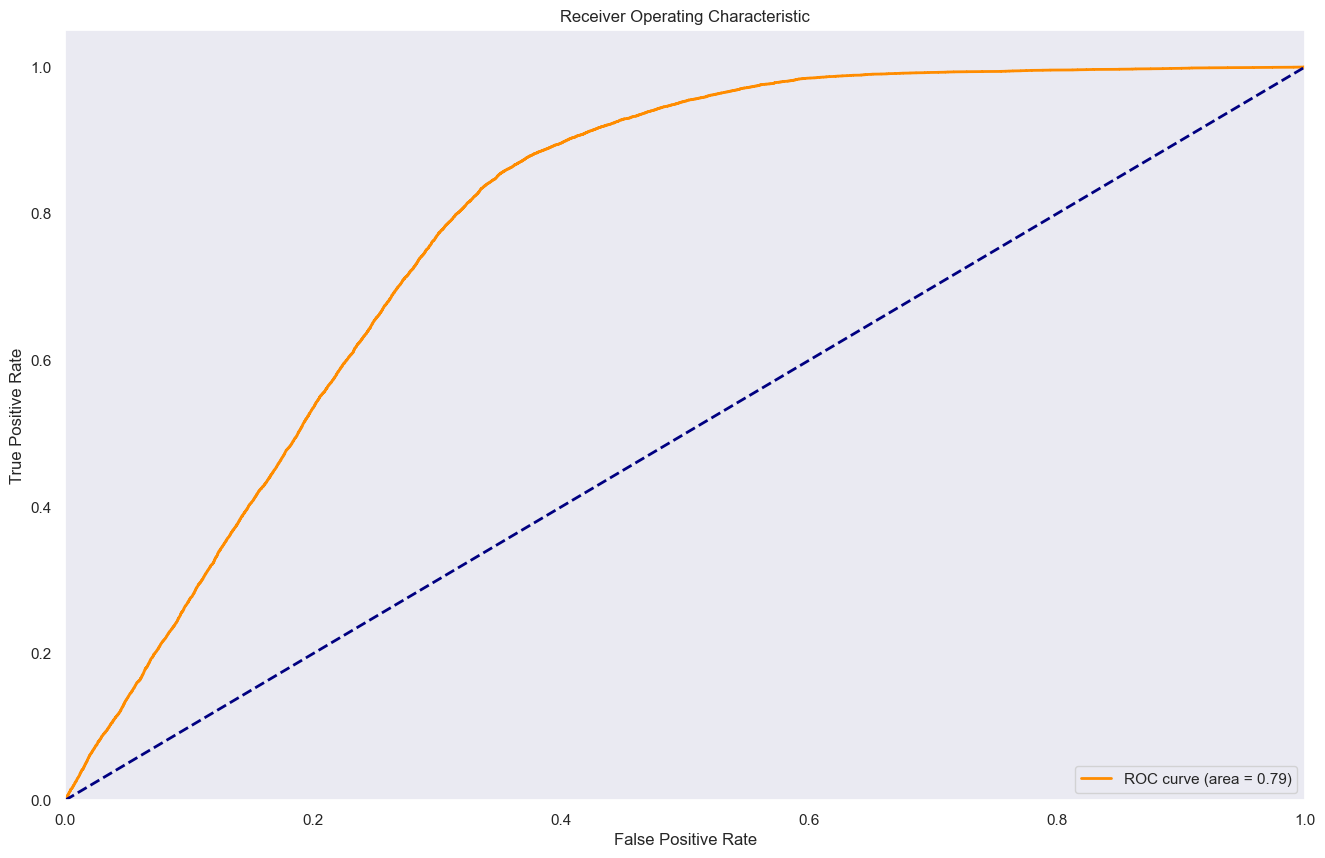

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [51]:
distances = np.sqrt((1-tpr)**2 + fpr**2)
index = np.argmin(distances)
best_threshold = thresholds[index]
print(f"Best threshold: {best_threshold}")

Best threshold: 0.4935907877127174


In [52]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
threshold = best_threshold
y_pred_threshold = (y_pred_proba >= threshold).astype(int)

In [53]:
accuracy_th = accuracy_score(y_test, y_pred_threshold)
precision_th = precision_score(y_test, y_pred_threshold)
recall_th = recall_score(y_test, y_pred_threshold)
f1_th = f1_score(y_test, y_pred_threshold)
roc_auc_th = roc_auc_score(y_test, y_pred_threshold)

In [54]:
print("Accuracy:", accuracy_th)
print("Precision:", precision_th)
print("Recall:", recall_th)
print("F1 Score:", f1_th)
print("ROC AUC Score:", roc_auc_th)

Accuracy: 0.6927221362161405
Precision: 0.2590863545272363
Recall: 0.8141548590239015
F1 Score: 0.39308295615520156
ROC AUC Score: 0.7449843436900514


Miglioramento del Recall, il modello aggiustato con la muova soglia riesce a predire i positivi ancora meglio. Occorre puntualizzare di nuovo la tendenza ad individuare falsi positivi.

Considerata la funzione del codice, ovvero stabilire chi vorrà acquistare o no una assicurazione, credo che sia fondamentale non "perdere" i casi postivi. Dunque avere un alto Recall, a discapito di qualche falso positivo, ritengo sia un risultato soddisfacente.